## Assess the significance

# with gkmSVM

In [1]:
import sys
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import numbers

In [2]:
def get_SNP_scores(filename, bind_scaler=0,dirsupt_scaler_pos=0,dirsupt_scaler_neg=0):
    bind_scores=list()
    disrupt_scores=list()
    svm_df=pd.read_csv(filename,sep="\t",header=0)
    bindref_column=svm_df['binding_ref'].tolist()
    bindalt_column=svm_df['binding_alt'].tolist()
    delta_column=svm_df['deltaSVM_score'].tolist()
    n=int(len(delta_column))
    
    for i in range(0,n):
        a=bindref_column[i]
        b=bindalt_column[i]
        bind_score = max(a,b)
        bind_scores.append(bind_score)
        disrupt_score=delta_column[i]
        disrupt_scores.append(disrupt_score)
    if bind_scaler==0:
        bind_scaler=max(bind_scores)
        dirsupt_scaler_pos=max([i for i in disrupt_scores if i >= 0] or None)
        dirsupt_scaler_neg=min([i for i in disrupt_scores if i < 0] or None)
    scaled_bind_scores=list(np.divide(np.array(bind_scores),bind_scaler))
    scaled_disrupt_scores=list()
    for score in disrupt_scores:
        if score>=0:
            newscore=score/dirsupt_scaler_pos
        else:
            newscore=-score/dirsupt_scaler_neg
        scaled_disrupt_scores.append(newscore)
    scaled_mod_scores=list(np.multiply(scaled_bind_scores,scaled_disrupt_scores))
    return bind_scaler,dirsupt_scaler_pos,dirsupt_scaler_neg,scaled_bind_scores,scaled_disrupt_scores,scaled_mod_scores

In [3]:
target_filename="gkm/STAT1_t.scores"
background_filename="gkm/STAT1_bg.scores"

In [4]:
bind_scaler,dirsupt_scaler_pos,dirsupt_scaler_neg,scaled_bind_scores_bg,scaled_disrupt_scores_bg,scaled_mod_scores_bg \
    = get_SNP_scores(background_filename)

In [5]:
bg_score_file = pd.read_csv(background_filename, sep="\t")
bg_score_file['scaled_binding_score'] = scaled_bind_scores_bg
bg_score_file['scaled_disrupt_score'] = scaled_disrupt_scores_bg
bg_score_file['scaled_area_score'] = scaled_mod_scores_bg
bg_score_file.to_csv("gkm/bg/STAT1/STAT1.scores", sep="\t", index=False)

In [6]:
bind_scaler,dirsupt_scaler_pos,dirsupt_scaler_neg,scaled_bind_scores_target,scaled_disrupt_scores_target,scaled_mod_scores_target \
    = get_SNP_scores(target_filename,bind_scaler,dirsupt_scaler_pos,dirsupt_scaler_neg)

In [7]:
t_score_file = pd.read_csv(target_filename, sep="\t")
t_score_file['scaled_binding_score'] = scaled_bind_scores_target
t_score_file['scaled_disrupt_score'] = scaled_disrupt_scores_target
t_score_file['scaled_area_score'] = scaled_mod_scores_target
t_score_file.to_csv("gkm/target/STAT1/STAT1.scores", sep="\t", index=False)

In [8]:
target_data=scaled_mod_scores_target
print("MAX scaled modularity scores target: "+str(max(target_data)))
print("MIN scaled modularity scores target: "+str(min(target_data)))
bg_data=scaled_mod_scores_bg
print("MAX scaled modularity scores background: "+str(max(bg_data)))
print("MIN scaled modularity scores background: "+str(min(bg_data)))

pop_mean=np.mean(bg_data)
pop_var=np.var(bg_data)
test_mean=pop_mean

test_var=pop_var/(len(target_data))


t=(np.mean(target_data)-test_mean)/((test_var)**(0.5))
report_pvalue_left=norm.cdf(t)
report_pvalue_right=1-report_pvalue_left
abs_target_data=np.abs(target_data)
abs_bg_data=np.abs(bg_data)
abs_pop_mean=np.mean(abs_bg_data)
abs_pop_var=np.var(abs_bg_data)
abs_test_mean=abs_pop_mean
abs_test_var=abs_pop_var/(len(abs_target_data))
if abs_test_var==0:
    abs_test_var=1E-20
abs_t=(np.mean(abs_target_data)-abs_test_mean)/((abs_test_var)**(0.5))
report_pvalue_abs=1-norm.cdf(abs_t)
print("Disruption p-value: "+str(report_pvalue_left))
print("Enhancement p-value: "+str(report_pvalue_right))
print("Dual p-value: "+str(report_pvalue_abs))

MAX scaled modularity scores target: 0.1412092490438486
MIN scaled modularity scores target: -0.19441591645011877
MAX scaled modularity scores background: 0.5093231359134706
MIN scaled modularity scores background: -0.5200226915524462
Disruption p-value: 6.652811142274561e-32
Enhancement p-value: 1.0
Dual p-value: 0.7240327972631122


In [9]:
def plot_motif_specific_main(snp_motif_result_file, bg_score_folder, motif_id_name, pngfilename):
    snp_motif_result_df=pd.read_csv(snp_motif_result_file, sep='\t')
    bg_filename=os.path.join(bg_score_folder,motif_id_name+".scores")
    SNP_score_dataframe=pd.read_csv(bg_filename,sep="\t")
    SNP_score_dataframe.set_index('snpID', inplace=True)
    score_df=SNP_score_dataframe[(SNP_score_dataframe['binding_ref']>0)|(SNP_score_dataframe['binding_alt']>0)]
    list_b=score_df['scaled_binding_score'] 
    list_a=score_df['scaled_disrupt_score']
    #hit_df_sub=snp_motif_result_df.loc[snp_motif_result_df['motif']==motif_id_name]
    bg_bind_scaled_score_list=snp_motif_result_df['scaled_binding_score']
    bg_disrupt_scaled_score_list=snp_motif_result_df['scaled_disrupt_score']

    fig = plt.figure(figsize=(10, 10), dpi=80, facecolor='w', edgecolor='w')
    ax = fig.add_subplot(111)
    plt.grid()
    #plt.plot([0, 1], [0, 0], 'k')
    #plt.plot([0, 0], [-1, 1], 'k')
    ##plot the points and then at the end
    ax.set_aspect('equal')
    plt.scatter(list_a, list_b, s=50,color='black',alpha=0.004)
    plt.scatter(bg_disrupt_scaled_score_list, bg_bind_scaled_score_list,  s=50,color='red')

    plt.ylabel('Binding score')
    plt.xlabel('Disruption score')
    plt.savefig(pngfilename)


    #plot area score distribution
    fig, axs = plt.subplots(1, 1, figsize=(10, 10))
    sns.distplot( score_df["scaled_area_score"] , color="black", bins=50, label="SNP-background", kde_kws={"bw":0.02})
    sns.distplot( snp_motif_result_df["scaled_area_score"] , color="red", bins=50, label="SNP-hits", kde_kws={"bw":0.02})
    #sns.plt.legend()
    #sns.plt.xlim(-1,1)
    #sns.plt.grid()
    plt.legend()
    plt.xlim(-1,1)
    plt.grid()
    axs.set(xlabel='Area Score')
    area_pdf_1=pngfilename.replace(".png","_area1.pdf")
    #sns.plt.savefig(area_pdf_1)
    plt.savefig(area_pdf_1)

    f, axes = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
    sns.distplot( score_df["scaled_area_score"] , color="black", bins=50, ax=axes[0],label="SNP-background")
    sns.distplot( snp_motif_result_df["scaled_area_score"] , color="red", bins=50, ax=axes[1], label="SNP-hits")
    #sns.plt.xlim(-1,1)
    plt.xlim(-1,1)
    axes[0].legend()
    axes[0].set(xlabel='')
    axes[0].grid(True)
    axes[1].legend()
    axes[1].set(xlabel='Area Score')
    axes[1].grid(True)
    area_pdf_2=pngfilename.replace(".png","_area2.pdf")
    #sns.plt.savefig(area_pdf_2)
    plt.savefig(area_pdf_2)

    #plot Q-Q plot for two samples
    X_array=np.array(score_df["scaled_area_score"])
    Y_array=np.array(snp_motif_result_df["scaled_area_score"])
    qqplot_pdf=pngfilename.replace(".png","_qqplot.pdf")
    fig=plt.figure(figsize=(10, 10), dpi=80)
    ax = fig.add_subplot(111)
    #a=X_array[1:2000]
    #b=X_array[4001:6000]
    #qqplot(a,b,c='r', alpha=0.5, edgecolor='k')
    qqplot(X_array, Y_array, c='r', alpha=0.5, edgecolor='k',quantiles=20)
    plt.plot([-1,1],[-1,1],'b--')
    plt.xlabel('SNP-background Area Score')
    plt.ylabel('SNP-hits Area Score')
    plt.tight_layout()
    #plt.title('Q-Q plot')
    plt.savefig(qqplot_pdf)

    X_all=score_df["scaled_area_score"].tolist()
    ind=np.random.choice(len(X_all), min(20000,len(X_all)), replace=False).tolist()
    X_list=[X_all[index] for index in ind]
    Y_list=snp_motif_result_df["scaled_area_score"].tolist()
    #ind=np.random.choice(len(Y_all), min(20000,len(Y_all)), replace=False).tolist()
    #Y_list = [Y_all[index] for index in ind]
    X_list_len=len(X_list)
    Y_list_len=len(Y_list)
    SNP_list=['background']*X_list_len+['hits']*Y_list_len
    Motif_list=[motif_id_name]*(X_list_len+Y_list_len)
    df_violinplot=pd.DataFrame([],index=range(0,X_list_len+Y_list_len), columns=['Area Score','Motif','SNP'])
    df_violinplot['Area Score']=X_list+Y_list
    df_violinplot['Motif']=Motif_list
    df_violinplot['SNP']=SNP_list
    violinplot_pdf=pngfilename.replace(".png","_violinplot.pdf")
    fig=plt.figure(figsize=(10, 10), dpi=80)
    ax = fig.add_subplot(111)
    palette ={"hits":"red", "background":"grey"}
    ax = sns.violinplot(x="Motif", y="Area Score", hue="SNP", data=df_violinplot, palette=palette, split=True, scale="area", inner="quartile", scale_hue=True,linewidth=1, bw=0.2)
    plt.tight_layout()    
    plt.savefig(violinplot_pdf)

In [10]:
def qqplot(x, y, quantiles=None, interpolation='nearest', ax=None, rug=False,
           rug_length=0.05, rug_kwargs=None, **kwargs):
    # Get current axes if none are provided
    if ax is None:
        ax = plt.gca()

    if quantiles is None:
        quantiles = min(len(x), len(y))

    # Compute quantiles of the two samples
    if isinstance(quantiles, numbers.Integral):
        quantiles = np.linspace(start=0, stop=1, num=int(quantiles))
    else:
        quantiles = np.atleast_1d(np.sort(quantiles))
    #x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
    a=pd.Series(x.tolist())
    x_quantiles = a.quantile(quantiles, interpolation=interpolation)
    #y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)
    b=pd.Series(y.tolist())
    y_quantiles = b.quantile(quantiles, interpolation=interpolation)
    # Draw the rug plots if requested
    if rug:
        # Default rug plot settings
        rug_x_params = dict(ymin=0, ymax=rug_length, c='gray', alpha=0.5)
        rug_y_params = dict(xmin=0, xmax=rug_length, c='gray', alpha=0.5)

        # Override default setting by any user-specified settings
        if rug_kwargs is not None:
            rug_x_params.update(rug_kwargs)
            rug_y_params.update(rug_kwargs)

        # Draw the rug plots
        for point in x:
            ax.axvline(point, **rug_x_params)
        for point in y:
            ax.axhline(point, **rug_y_params)

    # Draw the q-q plot
    ax.scatter(x_quantiles, y_quantiles, **kwargs)

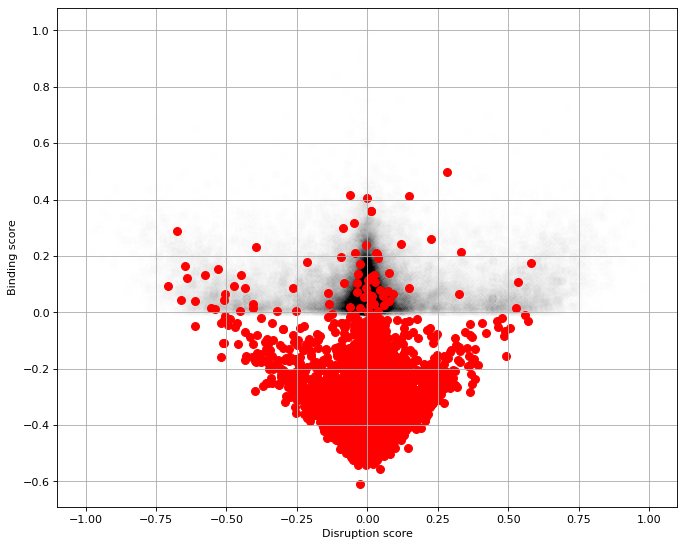

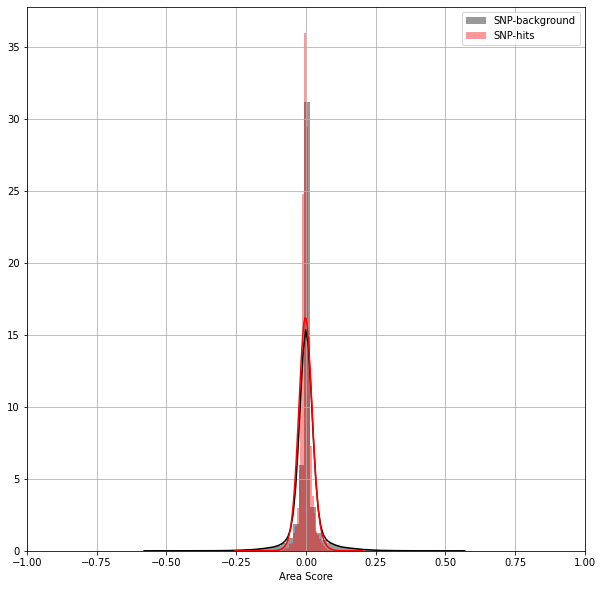

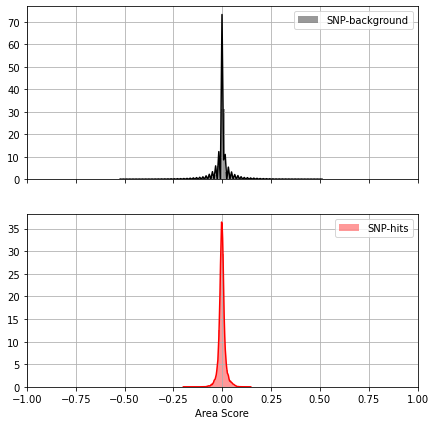

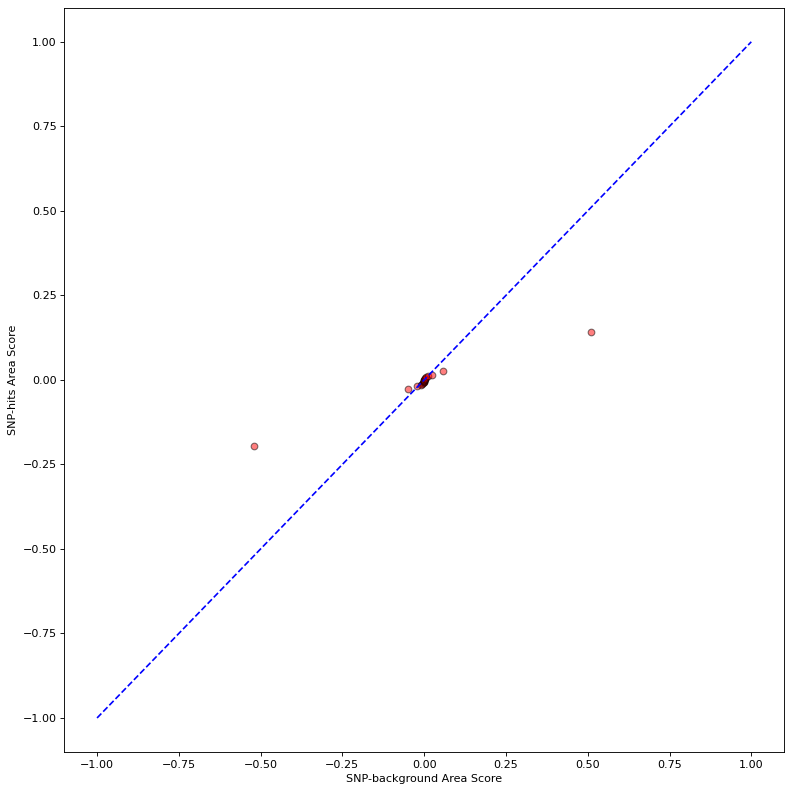

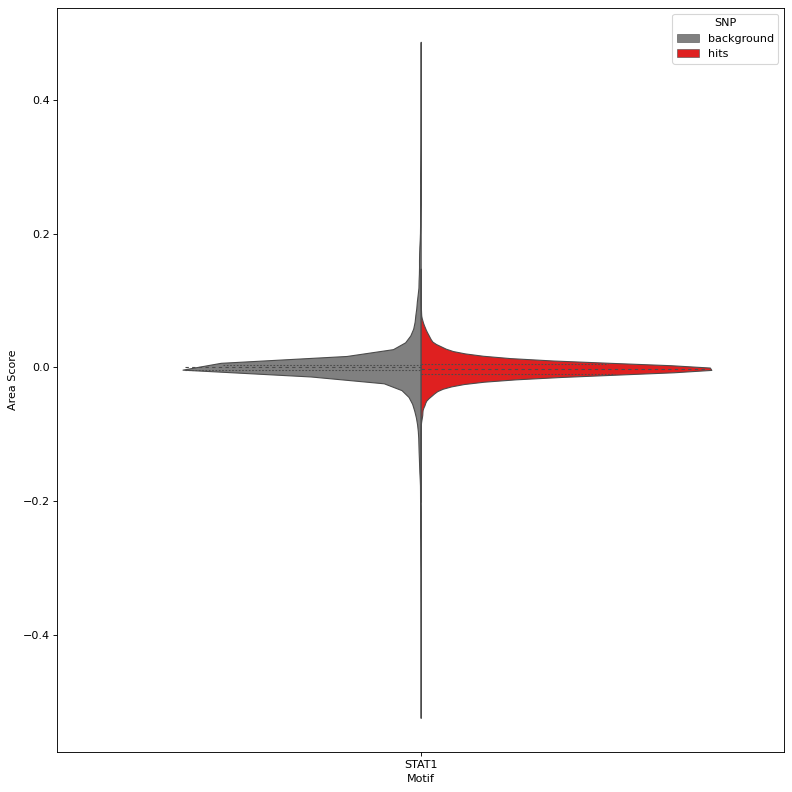

In [11]:
snp_motif_result_file='gkm/target/STAT1/STAT1.scores'
bg_score_folder='gkm/bg/STAT1/'
motif_id_name="STAT1"
pngfilename="plot_distribution_"+motif_id_name+".png"
plot_motif_specific_main(snp_motif_result_file, bg_score_folder, motif_id_name, pngfilename)

# with PWM

In [61]:
def get_SNP_scores(filename, bind_scaler=0,dirsupt_scaler_pos=0,dirsupt_scaler_neg=0):
    bind_scores=list()
    disrupt_scores=list()
    svm_df=pd.read_csv(filename,sep="\t",header=0)
    bindref_column=svm_df['binding_ref'].tolist()
    bindalt_column=svm_df['binding_alt'].tolist()
    n=int(len(bindref_column))
    
    for i in range(0,n):
        a=bindref_column[i]
        b=bindalt_column[i]
        bind_score = max(a,b)
        if bind_score>=0:
            bind_scores.append(bind_score)
            disrupt_score=b-a
            disrupt_scores.append(disrupt_score)
    if bind_scaler==0:
        bind_scaler=max(bind_scores)
        dirsupt_scaler_pos=max([i for i in disrupt_scores if i >= 0] or None)
        dirsupt_scaler_neg=min([i for i in disrupt_scores if i < 0] or None)
    scaled_bind_scores=list(np.divide(np.array(bind_scores),bind_scaler))
    scaled_disrupt_scores=list()
    for score in disrupt_scores:
        if score>=0:
            newscore=score/dirsupt_scaler_pos
        else:
            newscore=-score/dirsupt_scaler_neg
        scaled_disrupt_scores.append(newscore)
    scaled_mod_scores=list(np.multiply(scaled_bind_scores,scaled_disrupt_scores))
    return bind_scaler,dirsupt_scaler_pos,dirsupt_scaler_neg,scaled_bind_scores,scaled_disrupt_scores,scaled_mod_scores

In [62]:
target_filename="PWM/NFKB1_t.scores"
background_filename="PWM/NFKB1_bg.scores"

In [63]:
bind_scaler,dirsupt_scaler_pos,dirsupt_scaler_neg,scaled_bind_scores_bg,scaled_disrupt_scores_bg,scaled_mod_scores_bg \
    = get_SNP_scores(background_filename)

In [64]:
target = pd.read_csv(target_filename, sep='\t')
scaled_mod_scores_target = target['scaled_area_score']

In [65]:
target_data=scaled_mod_scores_target
bg_data=scaled_mod_scores_bg

pop_mean=np.mean(bg_data)
pop_var=np.var(bg_data)
test_mean=pop_mean

test_var=pop_var/(len(target_data))


t=(np.mean(target_data)-test_mean)/((test_var)**(0.5))
report_pvalue_left=norm.cdf(t)
report_pvalue_right=1-report_pvalue_left
abs_target_data=np.abs(target_data)
abs_bg_data=np.abs(bg_data)
abs_pop_mean=np.mean(abs_bg_data)
abs_pop_var=np.var(abs_bg_data)
abs_test_mean=abs_pop_mean
abs_test_var=abs_pop_var/(len(abs_target_data))
if abs_test_var==0:
    abs_test_var=1E-20
abs_t=(np.mean(abs_target_data)-abs_test_mean)/((abs_test_var)**(0.5))
report_pvalue_abs=1-norm.cdf(abs_t)
print("Disruption p-value: "+str(report_pvalue_left))
print("Enhancement p-value: "+str(report_pvalue_right))
print("Dual p-value: "+str(report_pvalue_abs))

Disruption p-value: 0.9993187156259269
Enhancement p-value: 0.00068128437407311
Dual p-value: 0.2672072678455292
